# Various Experiments #2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lib.calc as c
import scipy.ndimage as nd
from skimage import filters, measure, exposure, feature, color, morphology, restoration, data
%matplotlib qt5


### Data reading

Read the data and store it in the `data` dictionary. Access the intensity by calling `data[<scan_no>]['<roi>'][2]`.

In [3]:
sf = '/data/id01/inhouse/IHR/HC3313/spec/e17089_fast_00022.spec'
rois_103 = ['roi1', 'roi3', 'roi2', 'roi4', 'roi5']
scan_list = [10,15,21,27,33,39,45,51,57,63,69,75,80,85,90]

# for i,scan in enumerate(scan_list):
#     scan_list[i] = scan + 3
    
print(scan_list)    

data = dict()
for scan in scan_list:
    data[scan] = c.read_kmap(sf, scan, rois_103) # out is piy, pix, int per each roi

[10, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 80, 85, 90]


Prepare data. Select a roi and store all roi instensity per scan in the `data_roi` list:

In [4]:
roi = 'roi1'
data_roi = []
for scan in scan_list:
    data_roi.append(data[scan][roi][2].T[::-1]) # list of roi2 intensity ndarrays

### Pre-treatment

Smooth and compare histograms. Use a mean filter:

In [5]:
# Smooth
selem = morphology.selem.disk(1)
smoothed_data = filters.rank.mean(data_roi[0].astype('uint8'),selem)
hist, bins_centre = exposure.histogram(smoothed_data,nbins=smoothed_data.max())
hist2, bins_centre2 = exposure.histogram(data_roi[0],nbins=int(data_roi[0].max()-50))

# plot
fig, axes = plt.subplots(1,3,figsize=(13,4))
ax = axes.ravel()

ax[0].imshow(data_roi[0].astype(int)); ax[0].set_title('Original')
ax[1].imshow(smoothed_data); ax[2].set_title('Smoothed')
ax[2].plot(bins_centre,hist,bins_centre2,hist2); ax[2].set_title('Histograms');

Denoising and compare histograms. Use a median filter or a more complex algorithm.

In [69]:
img = data_roi[0] / data_roi[0].max()
sigma_est = restoration.estimate_sigma(img)

fig, ax = plt.subplots(1,2,figsize=(10,5))

# denoised_data = restoration.denoise_bilateral(data_roi[0], multichannel=False)
# denoised_data = filters.rank.median(img,selem)
denoised_data = restoration.denoise_nl_means(img, h=0.8*sigma_est)

ax[0].imshow(denoised_data)
hist, bins_centre = exposure.histogram(denoised_data)
ax[1].plot(bins_centre,hist)

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


See what kind of thresholding you can get with nl means + erosion

In [7]:
plt.imshow(denoised_data)

In [6]:
img = data_roi[0]
sigma_est = restoration.estimate_sigma(img)
denoised_data = restoration.denoise_nl_means(img, h=0.8*sigma_est)

ts_data = denoised_data > 0
ts_erode = morphology.erosion(ts_data, selem=morphology.selem.disk(2))

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(ts_data)
ax[1].imshow(ts_erode)

/users/zatterin/Envs/py3/lib/python3.5/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


### Edges to improve global thresholding

histogram of a reduced image region

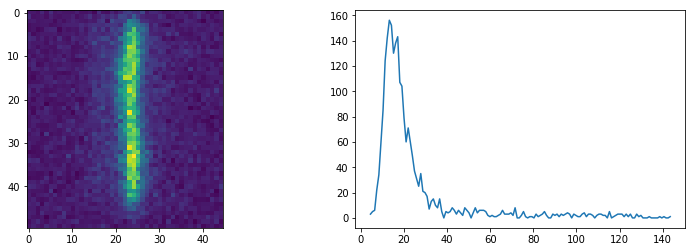

In [6]:
data = data_roi[0][40:90,40:85]#[40:90,60:65]
hist, bins_centre = exposure.histogram(data,nbins=int(data.max()))

fig, ax = plt.subplots(1,2,figsize=(13,4))

ax[0].imshow(data.astype(int))
ax[1].plot(bins_centre,hist);

See what the histogram around the edges of foreground features looks like:

67.8125


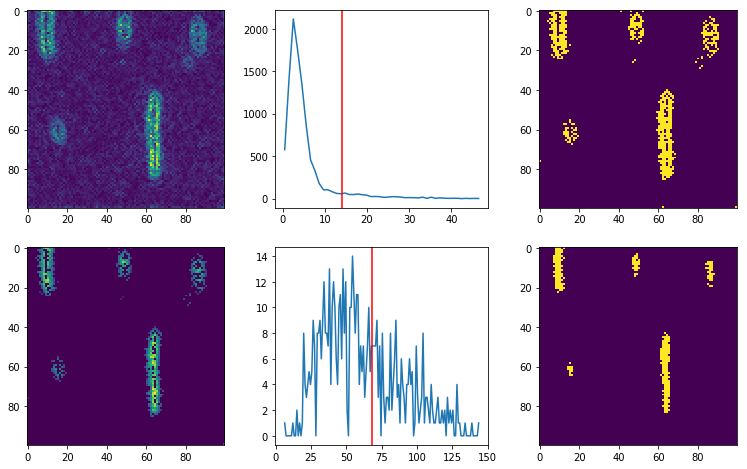

In [7]:
# Gradient
data = np.sqrt(np.gradient(data_roi[0])[0]**2+np.gradient(data_roi[0])[1]**2) # magnitude
hist, bins_centre = exposure.histogram(data,nbins=int(data.max())) # histogram

# Mask
threshold_grad = 0.3*data.max()
mask = np.zeros(data.shape)
mask[data>threshold_grad] = 1 

# Masked original data
masked_data = data_roi[0]*mask
masked_hist = exposure.histogram(masked_data[masked_data>0], nbins=int(masked_data.max()))

# Threshold the masked data
threshold_masked = filters.threshold_otsu(masked_data[masked_data>0], nbins=int(masked_data.max()))
print(threshold_masked)
final_data = np.zeros(data_roi[0].shape)
final_data[data_roi[0]>threshold_masked] = 1

fig, axes = plt.subplots(2,3,figsize=(13,8))
ax = axes.ravel()

ax[0].imshow(data)
ax[1].plot(bins_centre,hist)
ax[1].axvline(threshold_grad,c='r')
ax[2].imshow(mask)
ax[3].imshow(masked_data)
ax[4].plot(masked_hist[1],masked_hist[0])
ax[4].axvline(threshold_masked,c='r')
ax[5].imshow(final_data)

plt.show()

Plot histograms of roi images with voltage. It is obvious that most pixels are in the background - a foreground peak would have been on the right of the background one, but is absent (one would have a bimodal distribution):

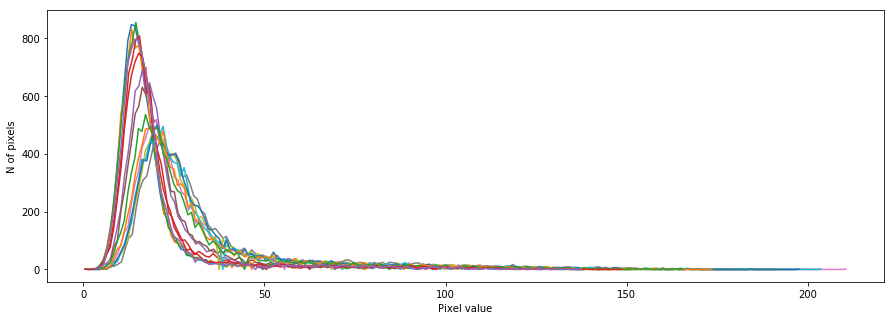

In [8]:
plt.figure(figsize=(15,5))
for scan in data_roi:
    hist, bins_centre = exposure.histogram(filters.gaussian(scan,sigma=0),nbins=int(scan.max()))
    plt.ylabel('N of pixels'); plt.xlabel('Pixel value')
    nhist = hist/scan.size # normalised histogram
    plt.plot(bins_centre,hist)

Comparison of histogram-based thresholding methods:

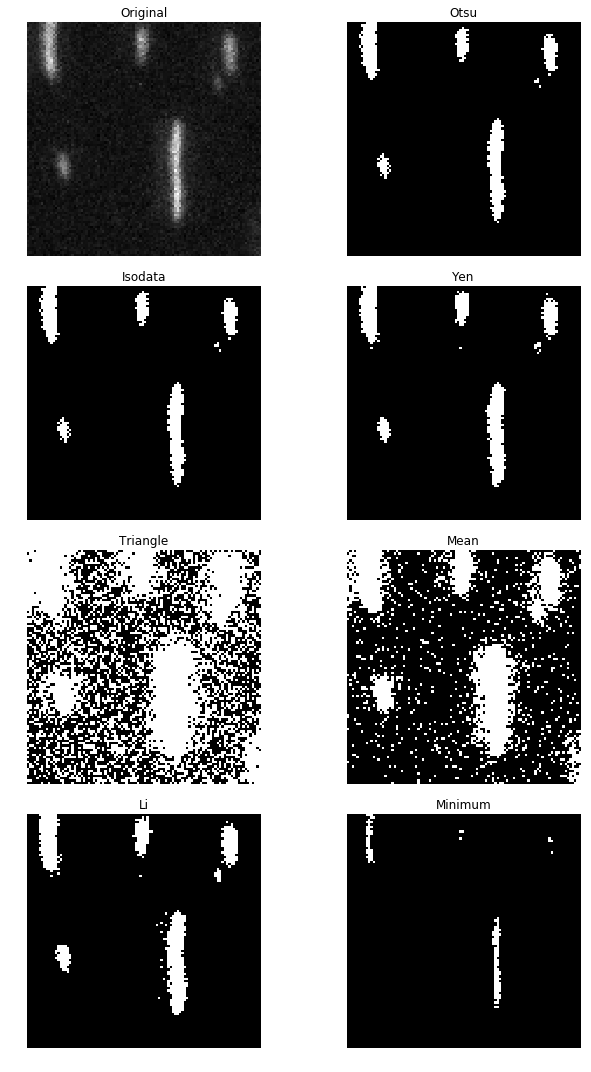

In [9]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(data_roi[0], figsize=(10,15), verbose=False)

Try local thresholding

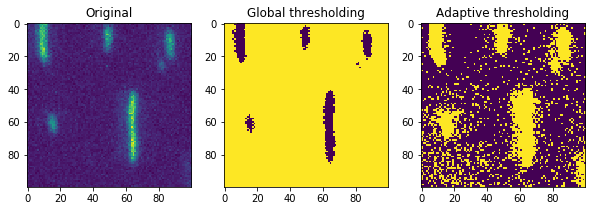

In [28]:
img = data_roi[0]

# Calc
global_thresh = filters.threshold_otsu(img,nbins=int(img.max()))
bin_img_global = img < global_thresh
block_size = 121
adaptive_thresh = filters.threshold_local(img, block_size, method='gaussian')
bin_img_local = img > adaptive_thresh

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(10, 8))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(bin_img_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(bin_img_local)
ax[2].set_title('Adaptive thresholding')

plt.show()

Try watershed (region-based segmentation). Input is gradient image and markers, separating features (basins) from background (outside the gradient determined "dams"):

Text(0.5,1,'Segmentation')

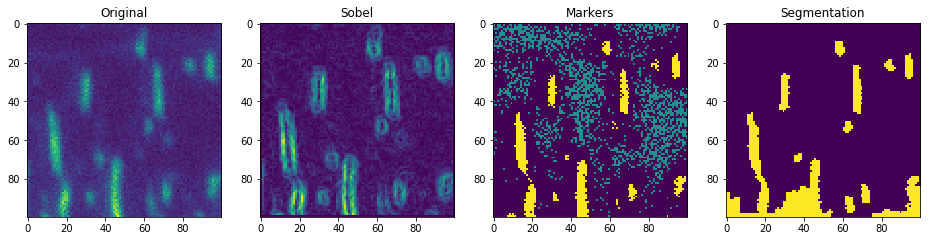

In [17]:
img = data_roi[10]

# Get edges
elevation_map = filters.sobel(img)
# grad2d = np.sqrt(np.gradient(img)[1]**2+np.gradient(img)[0]**2) # magnitude of 2D vector gradient
# elevation_map = feature.canny(img,sigma=2) # Canny filter

# Feed markers
markers = np.zeros_like(img)
# markers[img < filters.threshold_otsu(img,nbins=144)-10] = 1 # external markers - backround
# markers[img > filters.threshold_otsu(img,nbins=144)+10] = 2 # internal markers - basins
markers[img < 67.8125 - 50] = 1
markers[img > 67.8125 + 10] = 2
# markers = measure.label(markers,background=0)

# Compute watershed
seg = morphology.watershed(elevation_map,markers)

# Plot
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(elevation_map)
ax[1].set_title('Sobel') 


ax[2].imshow(markers)
ax[2].set_title('Markers')

ax[3].imshow(seg)
ax[3].set_title('Segmentation')

Perhaps the markers, instead of being determined by histogram thresholding, could be taken from the local maxima?

### Probe deconvolution

Load the probe:

In [420]:
last_res = np.load('/data/id01/inhouse/IHR/HC3313/analysis/ResultsScan0006/latest.npz')
probe = last_res['probe'][0] # use first mode only
print(probe.shape)

(264, 264)


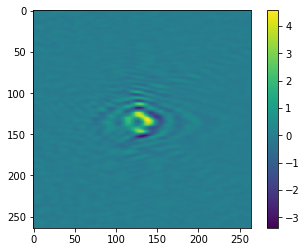

In [422]:
plt.imshow(probe.real)
plt.colorbar()

Size of probe with respect to image taken?